# Noise augmentation

Noise augmentation is widely used. We implement an array of noise 
distributions as well as additional utilities.

In [1]:
import torch
import matplotlib.pyplot as plt
from cornucopia.utils.py import meshgrid_ij
from cornucopia import (
    RandomGaussianMixtureTransform,
    GaussianNoiseTransform,
    ChiNoiseTransform,
    GammaNoiseTransform,
    GFactorTransform,
    RandomChiNoiseTransform,
)

Let's generate a synthetic label map. We use circles of varying radii.

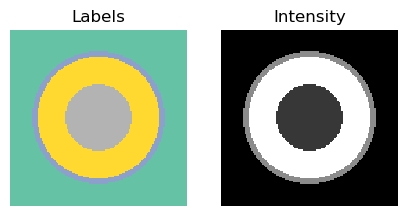

In [2]:
shape = [128, 128]
radius = torch.stack(meshgrid_ij(*[torch.arange(s).float() for s in shape]), -1)
radius -= (torch.as_tensor(shape).float() - 1) / 2
radius = radius.square().sum(-1).sqrt()

lab = torch.zeros_like(radius, dtype=torch.long)
lab[radius < 48] = 1
lab[radius < 44] = 2
lab[radius < 24] = 3
lab = lab[None]  # channel dimension

# we also generate an intenity image from this label map
img = RandomGaussianMixtureTransform(sigma=0)(lab)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(lab.squeeze(), cmap='Set2', interpolation='nearest')
plt.axis('off')
plt.title('Labels')
plt.subplot(1, 2, 2)
plt.imshow(img.squeeze(), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Intensity')
plt.show()

Additive Gaussian noise is the most widely type of augmentation noise. 
It is implemented in the `GaussianNoiseTransform` class, which takes 
a single `sigma` parameter that encodes its standard deviation. 

Note that by default, `shared=False`, meaning that a different noise map 
is generated for each channel and tensor. This is generally what one wants.
However, there is the possibility to apply the exact same noise map to 
different channels or tensors by setting `shared` to one of `"channels"`, 
`"tensors"` or `"channels+tensors"`. Note that if `"tensors"` is used, 
all tensors should have the same number of channels.

In [3]:
GaussianNoiseTransform?

Init signature: GaussianNoiseTransform(sigma=0.1, *, shared=False, **kwargs)
Docstring:      Additive Gaussian noise
Init docstring:
Parameters
----------
sigma : float
    Standard deviation

Keyword Parameters
------------------
returns : [list or dict of] {'input', 'output', 'noise'}
    Which tensors to return
shared : {'channels', 'tensors', 'channels+tensors', ''}
    Add the exact same nosie to all channels/images
File:           /autofs/space/pade_001/users/yb947/code/yb/cornucopia/cornucopia/noise.py
Type:           type
Subclasses:     

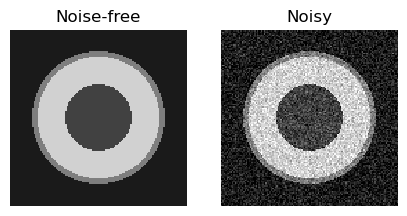

In [4]:
trf = GaussianNoiseTransform()
noisy = trf(img)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Noise-free')
plt.subplot(1, 2, 2)
plt.imshow(noisy.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy')
plt.show()

However, Gaussian noise may introduce negative values in an image that originally has none.

In MRI, the (noisy) acquisition is performed in the complex domain, and the resulting 
magnitude image is used. The noise in the magnitude image then follows a Rician distribution.
If more than a single acquisition channel is used -- which is common in neuroimaging with 
the use of phased-array coils -- the noise in the magnitude image follows a noncentral Chi 
distribution.

*Note:* The Rician distribution is a special case of the noncentral Chi distribution

We approximate this distribution by sampling noise from a Chi-squared distribution,
adding it to the square if the noise-free image, and taking the square root.

*Note:* Since the noise variance scales with the number of channels, the Chi-squared noise
is normalized by this number so that `sigma` approximately corresponds to the 
standard deviation of the final noisy image (in the limit of high SNR)

In [5]:
ChiNoiseTransform?

Init signature: ChiNoiseTransform(sigma=0.1, nb_channels=2, *, shared=False, **kwargs)
Docstring:     
Additive Noncentral Chi noise

(Rician is a special case with nb_channels = 2)
Init docstring:
Parameters
----------
sigma : float
    Standard deviation
nb_channels : int
    Number of independent channels

Keyword Parameters
------------------
returns : [list or dict of] {'input', 'output', 'noise'}
    Which tensors to return
shared : {'channels', 'tensors', 'channels+tensors', ''}
    Add the exact same values to all channels/images
File:           /autofs/space/pade_001/users/yb947/code/yb/cornucopia/cornucopia/noise.py
Type:           type
Subclasses:     

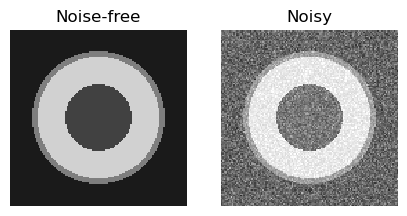

In [6]:
trf = ChiNoiseTransform(nb_channels=8)
noisy = trf(img)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Noise-free')
plt.subplot(1, 2, 2)
plt.imshow(noisy.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy')
plt.show()

It is quite clear that Rician/Chi noise modifies the mean value of the image. 
The presence of this "Rician bias" is well known, and an important confounds 
in quantitative MRI.

In some imaging problems, the noise is *multiplicative* instead of *additive*.
Multiplicative noise is common in optics, where it is referred to as "speckle".

We model speckle noise using a Gamma distribution, following:

Varadarajan, D., Magnain, C., Fogarty, M., Boas, D.A., Fischl, B. and Wang, H., 2022. 
[**A novel algorithm for multiplicative speckle noise reduction in ex vivo human brain OCT images.**](https://doi.org/10.1016/j.neuroimage.2022.119304)
_Neuroimage_, 257, p.119304.

In [7]:
GammaNoiseTransform?

Init signature: GammaNoiseTransform(sigma=0.1, mean=1, *, shared=False, **kwargs)
Docstring:      Multiplicative Gamma noise
Init docstring:
Parameters
----------
sigma : float
    Standard deviation
mean : float
    Expected value

Keyword Parameters
------------------
returns : [list or dict of] {'input', 'output', 'noise'}
    Which tensors to return
shared : {'channels', 'tensors', 'channels+tensors', ''}
    Use the exact same noise for all channels/tensors
File:           /autofs/space/pade_001/users/yb947/code/yb/cornucopia/cornucopia/noise.py
Type:           type
Subclasses:     

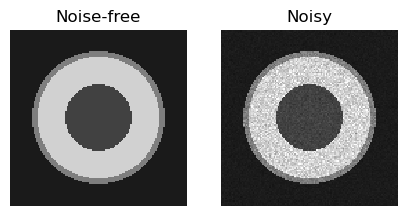

In [8]:
trf = GammaNoiseTransform()
noisy = trf(img)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Noise-free')
plt.subplot(1, 2, 2)
plt.imshow(noisy.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy')
plt.show()

There are also contexts in which the variance of the noise varies spatially.
This is for example the case when parallel imaging is used in MRI, in which 
case the local variance of the noise depends on the receive sensitivitty profiles.
The ratio between the parallel imaging variance and the variance that would be 
observed when the Fourier domain is fully sampled is known as the "g-factor".

We model these effects using a `GFactorTransform` meta class, which takes 
a `*NoiseTransform` as input and generates a smooth scaling map.

In [9]:
GFactorTransform?

Init signature:
GFactorTransform(
    noise,
    shape=5,
    vmin=0.5,
    vmax=1.5,
    *,
    shared=False,
    **kwargs,
)
Docstring:     
Mixin for transforms whose parameters depend on features
of the input transform (shape, dtype, etc)

Parameters
----------
shared : {'channels', 'tensors', 'channels+tensor', ''}

    - 'channel': the same transform is applied to all channels
        in a tensor, but different transforms are used in different
        tensors.
    - 'tensors': the same transform is applied to all tensors,
        but with a different transform for each channel.
    - 'channels+tensors' or True: the same transform is applied
        to all channels of all tensors.
    - '' or False: A different transform is applied to each
        channel and each tensor.
Init docstring:
Parameters
----------
noise : Transform
    A transform that applies additive noise
shape : float
    Number of control points
vmin : float
    Minimum g-factor
vmax : float
    Maximum g-factor



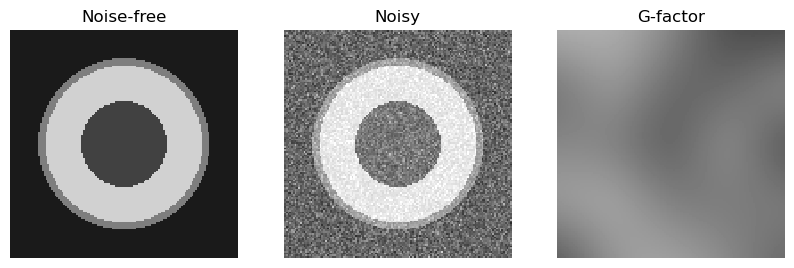

In [10]:
noise = ChiNoiseTransform(nb_channels=8)
gfactor = GFactorTransform(noise, returns=['output', 'gfactor'])
noisy, gmap = gfactor(img)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Noise-free')
plt.subplot(1, 3, 2)
plt.imshow(noisy.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy')
plt.subplot(1, 3, 3)
plt.imshow(gmap.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=2)
plt.axis('off')
plt.title('G-factor')
plt.show()

All of these transforms come with a randomized variant, where the 
standard deviation (and number of channels) is randomly sampled.

In [11]:
RandomChiNoiseTransform?

Init signature:
RandomChiNoiseTransform(
    sigma=0.1,
    nb_channels=8,
    *,
    shared=False,
    shared_noise=None,
    **kwargs,
)
Docstring:      Additive Chi noise with random standard deviation and channels
Init docstring:
Parameters
----------
sigma : Sampler or float
    Distribution from which to sample the standard deviation.
    If a `float`, sample from `Uniform(0, value)`.
    To use a fixed value, pass `Fixed(value)`.
nb_channels : Sampler or int
    Distribution from which to sample the standard deviation.
    If a `int`, sample from `RandInt(1, value)`.
    To use a fixed value, pass `Fixed(value)`.

Keyword Parameters
------------------
returns : [list or dict of] {'input', 'output', 'noise'}
    Which tensors to return
shared : {'channels', 'tensors', 'channels+tensors', ''}
    Use the same sd for all channels/tensors
shared_noise : {'channels', 'tensors', 'channels+tensors', '', None}
    Use the exact same noise for all channels/tensors
File:           /autofs

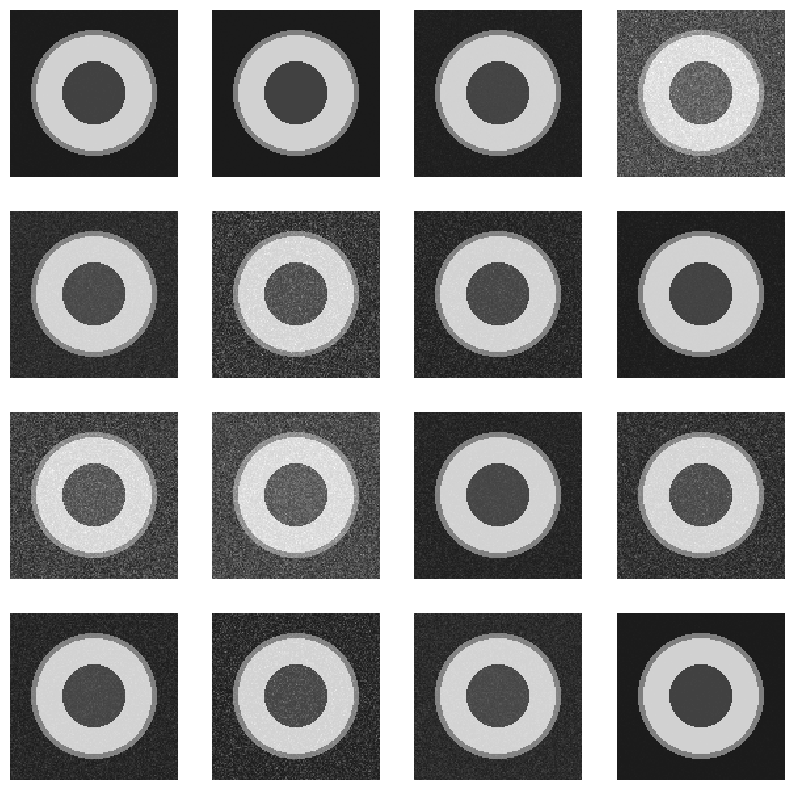

In [12]:
trf = RandomChiNoiseTransform()
noisy = trf(img)

shape = (4, 4)
plt.figure(figsize=(10, 10))
for i in range(shape[0]*shape[1]):
    noisy = trf(img)
    plt.subplot(*shape, i+1)
    plt.imshow(noisy.squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.axis('off')
plt.show()